

# BERT+CRF_graph_refinement ATE-it



## Install of the required packages for this project


In [1]:


!pip install -q pytorch-crf seqeval transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torchcrf import CRF
import numpy as np
import networkx as nx
from itertools import combinations

##Load training set and development set


In [3]:

import json
def load_jsonl(path: str):
    """Load a JSON lines file or JSON array file."""
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read().strip()
    if not text:
        return []
    try:
        data = json.loads(text)
    except json.JSONDecodeError:
        data = []
        for line in text.splitlines():
            line = line.strip()
            if line:
                data.append(json.loads(line))
    return data


def build_sentence_gold_map(records):
    """Convert dataset rows into list of sentences with aggregated terms."""
    out = {}

    if isinstance(records, dict) and 'data' in records:
        rows = records['data']
    else:
        rows = records

    for r in rows:
        key = (r.get('document_id'), r.get('paragraph_id'), r.get('sentence_id'))
        if key not in out:
            out[key] = {
                'document_id': r.get('document_id'),
                'paragraph_id': r.get('paragraph_id'),
                'sentence_id': r.get('sentence_id'),
                'sentence_text': r.get('sentence_text', ''),
                'terms': []
            }

        if isinstance(r.get('term_list'), list):
            for t in r.get('term_list'):
                if t and t not in out[key]['terms']:
                    out[key]['terms'].append(t)
        else:
            term = r.get('term')
            if term and term not in out[key]['terms']:
                out[key]['terms'].append(term)

    return list(out.values())


print("✓ Data loading functions defined")


from google.colab import drive
drive.mount('/content/drive')


train_data = load_jsonl('/content/drive/MyDrive/Colab Notebooks/data/subtask_a_train.json')
dev_data = load_jsonl('/content/drive/MyDrive/Colab Notebooks/data/subtask_a_dev.json')

train_sentences = build_sentence_gold_map(train_data)
dev_sentences = build_sentence_gold_map(dev_data)

print(f"Training sentences: {len(train_sentences)}")
print(f"Dev sentences: {len(dev_sentences)}")
print(f"\nExample sentence:")
print(f"  Text: {train_sentences[6]['sentence_text']}")
print(f"  Terms: {train_sentences[6]['terms']}")

✓ Data loading functions defined
Mounted at /content/drive
Training sentences: 2308
Dev sentences: 577

Example sentence:
  Text: AFFIDAMENTO DEL “SERVIZIO DI SPAZZAMENTO, RACCOLTA, TRASPORTO E SMALTIMENTO/RECUPERO DEI RIFIUTI URBANI ED ASSIMILATI E SERVIZI COMPLEMENTARI DELLA CITTA' DI AGROPOLI” VALEVOLE PER UN QUINQUENNIO
  Terms: ['raccolta', 'recupero', 'servizio di raccolta', 'servizio di spazzamento', 'smaltimento', 'trasporto']


## Load of Test set

In [4]:

import json, re

test_path = "/content/drive/MyDrive/Colab Notebooks/data/test.json"

# Read file and clean noisy chars
with open(test_path, "r", encoding="utf-8", errors="ignore") as f:
    raw = f.read().replace("\ufeff", "").strip()

# Extract all JSON objects {...}
objects = re.findall(r"\{.*?\}", raw, flags=re.DOTALL)

# Parse each object
test_data = []
for obj in objects:
    try:
        test_data.append(json.loads(obj))
    except:
        pass

print("Loaded entries:", len(test_data))
print("Example:", test_data[0])

# Convert to expected model format (no gold terms in test set)
test_sentences = [
    {"sentence_text": x.get("sentence_text", ""), "terms": []}
    for x in test_data
]

print("\nFormatted example:", test_sentences[0])
print("Total:", len(test_sentences))


Loaded entries: 1141
Example: {'document_id': 'amato_01', 'paragraph_id': 1, 'sentence_id': 2, 'sentence_text': 'PROVINCIA DI CATANZARO'}

Formatted example: {'sentence_text': 'PROVINCIA DI CATANZARO', 'terms': []}
Total: 1141


##Load of training set, development set and test set without mounting the drive
(uncomment to use it)

In [5]:
from google.colab import files
import json, re




#def upload_and_load_jsonl():
#    #Upload a JSONL or JSON array file (train/dev).
#    uploaded = files.upload()
#    fname = list(uploaded.keys())[0]

#    text = open(fname, 'r', encoding='utf-8').read().strip()
#    if not text:
#        return []

#    # JSON array
#    try:
#        return json.loads(text)
#    except json.JSONDecodeError:
#        pass

#    # JSONL
#    data = []
#    for line in text.splitlines():
#        line = line.strip()
#        if line:
#            data.append(json.loads(line))
#    return data


##Training sentences
#print("Upload TRAIN file:")
#train_raw = upload_and_load_jsonl()
#train_sentences = build_sentence_gold_map(train_raw)
#print("Training sentences:", len(train_sentences))



#
##Development senteces
#print("Upload DEV file:")
#dev_raw = upload_and_load_jsonl()
#dev_sentences = build_sentence_gold_map(dev_raw)
#print("Dev sentences:", len(dev_sentences))









#def upload_and_load_test_sentences():
#    """
#    #Upload a JSON/JSONL/concatenated-JSON test file
#    #and convert it into the standard inference format:
#        { "sentence_text": "...", "terms": [] }
#    """
#    uploaded = files.upload()
#    fname = list(uploaded.keys())[0]

#    #  Read raw text
#    raw = open(fname, "r", encoding="utf-8", errors="ignore").read()
#    raw = raw.replace("\ufeff", "").strip()


#    #  {…}{…}{…}
#    if len(data) == 0:
#        blocks = re.findall(r"\{.*?\}", raw, flags=re.DOTALL)
#        for b in blocks:
#            try:
#                data.append(json.loads(b))
#            except:
#                pass

#    # Convert to model format
#    test_sentences = [
#        {
#            "sentence_text": item.get("sentence_text", ""),
#            "terms": []   # TEST SET = no gold labels
#        }
#        for item in data
#    ]

#    return test_sentences

## TYPE METRIC AND MICRO-METRICS FUNCTIONS

In [6]:
def type_f1_score(gold_standard, system_output):

    # gold terms with no repetitions
    all_gold_terms = set()
    for item_terms in gold_standard:
        #normalization
        all_gold_terms.update(t.strip().lower() for t in item_terms)

    # Predicted terms with no repetitions and normalized
    all_system_terms = set()
    for item_terms in system_output:
        all_system_terms.update(t.strip().lower() for t in item_terms)

    type_true_positives = len(all_gold_terms.intersection(all_system_terms))
    type_false_positives = len(all_system_terms - all_gold_terms)
    type_false_negatives = len(all_gold_terms - all_system_terms)

    # Metrics calculations
    type_precision = type_true_positives / (type_true_positives + type_false_positives) if (type_true_positives + type_false_positives) > 0 else 0
    type_recall = type_true_positives / (type_true_positives + type_false_negatives) if (type_true_positives + type_false_negatives) > 0 else 0
    type_f1 = 2 * (type_precision * type_recall) / (type_precision + type_recall) if (type_precision + type_recall) > 0 else 0


    print("\n--- TYPE-LEVEL METRICS ---")
    print(f"Type Precision={type_precision:.4f} Type Recall={type_recall:.4f} Type F1={type_f1:.4f}")
    print(f"Type TP={type_true_positives}, Type FP={type_false_positives}, Type FN={type_false_negatives}")

    return type_precision, type_recall, type_f1


def micro_f1_score(gold_standard, system_output):
    gold_s = set()
    pred_s = set()


    for i, (g, p) in enumerate(zip(gold_standard, system_output)):
        for t in g:
            gold_s.add((i, t.strip().lower()))
        for t in p:
            pred_s.add((i, t.strip().lower()))


    tp = len(gold_s.intersection(pred_s))
    fp = len(pred_s - gold_s)
    fn = len(gold_s - pred_s)

    # Metrics calculations
    P = tp / (tp + fp) if tp + fp > 0 else 0
    R = tp / (tp + fn) if tp + fn > 0 else 0
    F = 2 * P * R / (P + R) if P + R > 0 else 0


    print("\n--- MICRO METRICS ---")
    print(f"Precision={P:.4f} Type Recall={R:.4f} Type F1={F:.4f}")
    print(f"Type TP={tp}, Type FP={fp}, Type FN={fn}")

    return P, R, F, tp, fp, fn


print("✓ Evaluation functions defined")

✓ Evaluation functions defined


## Tokenizer


In [7]:


#We use bert-base-italian-cased since the term extraction is on an italian dataset
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-cased")

label_map = {"O":0, "B":1, "I":2}
inv_label_map = {v:k for k,v in label_map.items()}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

## Span of the terms within the document


In [8]:
#Find the index of the span within the document
def find_char_spans(sentence, term):
    sentence_l = sentence.lower()
    term_l = term.lower().strip()

    spans = []
    start = 0

    while True:
        idx = sentence_l.find(term_l, start)
        if idx == -1:
            break
        spans.append((idx, idx + len(term_l)))
        start = idx + 1

    return spans


## Tagging of the sentences


In [9]:

def encode_with_BIO_labels(sentence, terms, tokenizer):
    enc = tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=False)
    offsets = enc["offset_mapping"]
    input_ids = enc["input_ids"]
    labels = [label_map["O"]] * len(input_ids) # Initialize everything as 'O'

    for term in terms:
        spans = find_char_spans(sentence, term)
        for (start_c, end_c) in spans:
            in_entity = False
            for i, (s, e) in enumerate(offsets):

                #if it is in the left
                if e <= start_c: continue
                # if it is in the right
                if s >= end_c: break

                # if the token is within the term


                if not in_entity:
                    labels[i] = label_map["B"]
                    in_entity = True # From here on we are inside the entity
                else:
                    labels[i] = label_map["I"]

    return input_ids, labels, offsets

## Function to encode the data (sentences)


In [10]:

def encode_for_inference(sentence, tokenizer):
    enc = tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=False) #we mantain the indices of the subtokens
    return enc["input_ids"], enc["offset_mapping"]


## Custom Dataset and dynamic padding

In [11]:


#Class to develop interface between preprocessed data and PyTorch's DataLoader
class BIO_Dataset(Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]


#Function to make each sentence have the same length within the batch
def pad_batch(batch):
    max_len = max(len(x["input_ids"]) for x in batch)
    ids=[]; labs=[]; mask=[]
    for x in batch:
        L=len(x["input_ids"])
        pad=max_len-L
        ids.append(x["input_ids"] + [0]*pad)
        labs.append(x["labels"] + [0]*pad)
        mask.append([1]*L + [0]*pad)
    return {
        "input_ids": torch.tensor(ids),
        "labels": torch.tensor(labs),
        "attention_mask": torch.tensor(mask)
    }


## BERT + Conditional Random Field layer


In [12]:
#In this cell we define the model we are going to use to predict the terms

class BERT_CRF(nn.Module):
    def __init__(self, model_name="dbmdz/bert-base-italian-cased", num_labels=3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels) #Linear layer to go from dimension of bert (768) to the number of labels(3 BIO)
        self.crf = CRF(num_labels, batch_first=True) #CRF models the probability of transitions between tags (generate some consistency)

    def forward(self, ids, mask, labels=None):
        out = self.bert(input_ids=ids, attention_mask=mask)
        logits = self.classifier(out.last_hidden_state)
        if labels is not None:
            loss = -self.crf(logits, labels, mask=mask.bool(), reduction="mean")
            return loss
        else:
            return self.crf.decode(logits, mask=mask.bool())


## Training Phase


In [13]:


# Encoding of sentences from the training set
encoded_train=[]
for s in train_sentences:
    ids, labs, off = encode_with_BIO_labels(s["sentence_text"], s.get("terms",[]), tokenizer)
    encoded_train.append({"input_ids": ids, "labels": labs})

# Encoding of sentences from the development set
encoded_dev=[]
for s in dev_sentences:
    ids, labs, off = encode_with_BIO_labels(s["sentence_text"], s.get("terms",[]), tokenizer)
    encoded_dev.append({"input_ids": ids, "labels": labs})

# Data loading
train_loader = DataLoader(BIO_Dataset(encoded_train), batch_size=8, shuffle=True, collate_fn=pad_batch)
dev_loader   = DataLoader(BIO_Dataset(encoded_dev),   batch_size=8, shuffle=False, collate_fn=pad_batch)


# Setup of the device used
device="cuda" if torch.cuda.is_available() else "cpu"
model=BERT_CRF().to(device)

# Discriminative learning rate
bert_lr = 3.7e-5    # Learning rate for Bert, small in order to mantain enough knowledge
new_layers_lr = 1e-3 # For last layers the learning rate must be higher in order to learn in 5 epochs enough patterns


# Group parameters on the basis of the learning rate to use
optimizer_grouped_parameters = [
    {'params': model.bert.parameters(), 'lr': bert_lr},
    {'params': list(model.classifier.parameters()) + list(model.crf.parameters()), 'lr': new_layers_lr},
]

#use AdamW to prevent overfitting issues
optimizer=torch.optim.AdamW(optimizer_grouped_parameters)


epochs = 5 #epochs used for the training
for ep in range(epochs):
    model.train()
    tot=0
    for batch in train_loader:
        ids=batch["input_ids"].to(device)
        labs=batch["labels"].to(device)
        mask=batch["attention_mask"].to(device)

        # Forward Pass
        loss=model(ids,mask,labs)

        # Backward Pass
        optimizer.zero_grad() #to prevent accumulations of gradients
        loss.backward()
        optimizer.step() # update weights
        tot+=loss.item()

    print(f"Epoch {ep+1}/{epochs} - Loss: {tot/len(train_loader):.4f}")


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Epoch 1/5 - Loss: 6.4490
Epoch 2/5 - Loss: 2.8680
Epoch 3/5 - Loss: 1.5027
Epoch 4/5 - Loss: 0.8631
Epoch 5/5 - Loss: 0.6879


## Save the Model






In [ ]:

crf_encoder_dir = "models/crf_encoder_best"

# Save the encoder and the tokenizer in Hugging Face format
# Later they will be used for the graph enhancement part
model.bert.save_pretrained(crf_encoder_dir)
tokenizer.save_pretrained(crf_encoder_dir)

print(f"✓ Encoder BERT_CRF saved in: {crf_encoder_dir}")

## From BIO tags to terms


In [15]:

def bio_to_terms(sentence, offsets, pred_ids):
    spans=[]
    cur=[]
    for (s,e),lab in zip(offsets, pred_ids): # couple the id of each subtoken with its ID
        tag=inv_label_map[lab] # from ID to TAG
        if tag=="B": # beginning of the term
            if cur: spans.append(cur)
            cur=[(s,e)]
        elif tag=="I" and cur:
            cur.append((s,e))
        else:
            if cur: spans.append(cur) # end of the term
            cur=[]
    if cur: spans.append(cur)

    terms=[]
    for toks in spans: # iterates on the spans reconstructed
        st=toks[0][0]; en=toks[-1][1] # Impose the start on the first character of first subtoken and the end on the last character of last subtoken
        terms.append(sentence[st:en]) # Based on the indices obtained extract the term  from the original sentence and append to terms list

    return terms


## Inference on development set


In [16]:



crf_predictions=[] # list of terms that will be extracted
model.eval() # evaluation mode
with torch.no_grad(): # no gradient calculations to reduce computational time
    for s in dev_sentences:
        ids, offsets = encode_for_inference(s["sentence_text"], tokenizer) # Data preprocessing
        inp=torch.tensor([ids]).to(device) # Tranform into a tensor in order to work with GPU
        mask=torch.tensor([[1]*len(ids)]).to(device)
        pred = model(inp,mask)[0] #prediction of sequence of tags
        crf_predictions.append(bio_to_terms(s["sentence_text"], offsets, pred)) # we populate the list of terms predicted after transforming them using the function defined previously

#crf_predictions will be the input for the construction of the graph to refine the method


## Evaluation of the predictions on the Development set

In [17]:

#It appears that the optimal learning rates are 3.7e-5 for bert and 1e-3 for CRF while I used 5 epochs

#Type_f1_score
type_f1_score([s["terms"] for s in dev_sentences], crf_predictions)

#Micro metrics
micro_f1_score([s["terms"] for s in dev_sentences], crf_predictions)








--- TYPE-LEVEL METRICS ---
Type Precision=0.6698 Type Recall=0.5950 Type F1=0.6302
Type TP=144, Type FP=71, Type FN=98

--- MICRO METRICS ---
Precision=0.7314 Type Recall=0.6763 Type F1=0.7028
Type TP=305, Type FP=112, Type FN=146


(0.7314148681055156, 0.6762749445676275, 0.7027649769585254, 305, 112, 146)

## Post-Processing refinements

This section describes an enhancement for the BERT+CRF model. I first constructed a co-occurence graph based on the gold terms of training data which later I augmented by exploiting syntactic relations obtained using Spacy. Eventually I calculated Page rank centrality in order to define global domain importance. <br>
Simultaneously I enriched the domain vocabulary by using a few-shot prompting technique using Groq. The LLM was instructed to extract terms regarding waste management from an external corpora. In particular I used "Parte IV del D.Lgs. 152/2006". In order to obtain even more remarkable results one may augment the corpora by including other legislative documents regarding the domain of interest. The terms extracted were used along with gold term of the training set to define an embedding space that was used to compute similarity with the terms found at inference time. <br>
In the end I implemented a hybrid filtering score combining Graph Centrality (PageRank) with a weight of $\mathbf{0.4}$ and Semantic Similarity (from our augmented embedding space) with a weight of $\mathbf{1-\alpha=0.6}$.


In [18]:

import networkx as nx

def normalize_term(t: str) -> str:
    return t.strip().lower()

print("Building term co-occurrence graph from TRAIN gold terms...")

G = nx.Graph()

for sent in train_sentences:
    raw_terms = sent.get('terms', [])
    terms = [normalize_term(t) for t in raw_terms if t and t.strip()]
    unique_terms = list(set(terms))
    if not unique_terms:
        continue

    # add or update nodes
    for term in unique_terms:
        if term not in G:
            G.add_node(term, freq=0)
        G.nodes[term]['freq'] += 1

    # add or update edges for co-occurring terms
    from itertools import combinations
    for t1, t2 in combinations(unique_terms, 2):
        if G.has_edge(t1, t2):
            G[t1][t2]['weight'] += 1
        else:
            G.add_edge(t1, t2, weight=1)

print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
#how important is each node in the graph (is a recursive importance measure)
print("Computing PageRank centrality over term graph...")
centrality = nx.pagerank(G, weight='weight')
print("PageRank centrality computed")

# pre-compute min/max centrality for normalization
c_values = np.array(list(centrality.values()))
c_min = float(c_values.min()) if len(c_values) > 0 else 0.0
c_max = float(c_values.max()) if len(c_values) > 0 else 1.0
eps = 1e-8 # to prevent division by zero
print(f"Centrality range: min={c_min:.6f}, max={c_max:.6f}")

Building term co-occurrence graph from TRAIN gold terms...
Graph built: 713 nodes, 1451 edges
Computing PageRank centrality over term graph...
PageRank centrality computed
Centrality range: min=0.000258, max=0.022605


## Syntactic enhancement of the Graph by using Spacy


In [19]:

!python -m spacy download it_core_news_lg
import spacy
nlp = spacy.load("it_core_news_lg")

print("Enhancing existing term graph with spaCy syntactic information...")

for sent in train_sentences:
    text = sent["sentence_text"]
    raw_terms = sent.get("terms", [])
    terms = [normalize_term(t) for t in raw_terms if t and t.strip()]

    # there has to be at least a pair of words in the term
    if len(terms) < 2:
        continue

    # lemmatize all the terms
    term_lemmas = {
        t: " ".join(tok.lemma_.lower() for tok in nlp(t))
        for t in terms
    }

    # parse the document
    doc = nlp(text)


    #for each record the positions of tokens which match the lemma
    term_positions = {}
    for t, lemma in term_lemmas.items():
        lemma_head = lemma.split()[0]
        pos = [token.i for token in doc if token.lemma_.lower() == lemma_head]
        if pos:
            term_positions[t] = pos

    # enhancement term-term
    from itertools import combinations
    for t1, t2 in combinations(term_positions.keys(), 2):
        pos1 = term_positions[t1]
        pos2 = term_positions[t2]

        # define minimum distance between two terms
        min_dist = min(abs(a - b) for a in pos1 for b in pos2)

        # heuristics rules to change edge weights
        if min_dist <= 2:
            w = 15
        elif min_dist <= 5:
            w = 10
        else:
            w = 1

        # update weights
        if G.has_edge(t1, t2):
            G[t1][t2]['weight'] += w
        else:
            G.add_edge(t1, t2, weight=w)

        # Since it is a non oriented graph we have to update both directions
        if G.has_edge(t2, t1):
            G[t2][t1]['weight'] += w
        else:
            G.add_edge(t2, t1, weight=w)

print(" spaCy enhancement completed.")
print(f"Graph now: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.9/567.9 MB 2.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Enhancing existing term graph with spaCy syntactic information...
 spaCy enhancement completed.
Graph now: 713 nodes, 1451 edges


## Recompute the centrality values after the syntactic enhancement

Actually the enhancement does not improve too much the centrality values since the documents are often short. This would work better if there were multiple terms within the same document

In [20]:

import numpy as np
import networkx as nx


print("Recomputing PageRank after spaCy enhancement...")

centrality = nx.pagerank(G, weight="weight")
c_values = np.array(list(centrality.values()))
c_min = float(c_values.min()) if len(c_values)>0 else 0.0
c_max = float(c_values.max()) if len(c_values)>0 else 1.0

print("PageRank recalculated with updated graph")
print("New centrality range:", c_min, "to", c_max)

Recomputing PageRank after spaCy enhancement...
PageRank recalculated with updated graph
New centrality range: 0.0002576876825291253 to 0.021574097297293655


## Collect domain terms


In [21]:
domain_terms = list(centrality.keys())
print(f"Initial domain terms from PageRank graph: {len(domain_terms)}")

Initial domain terms from PageRank graph: 713


## Few shot prompting using Groq LLM

In [22]:

#Since the API key is personal and I cannot publish it I will save the terms in a document that later can be reused, at each run the LLM may extract different terms.

#Create a semantic space by using Groq LLM to extract terms (using prompting) from a text with similar domain to the training set then i will create encodings of those terms


from google.colab import drive
drive.mount('/content/drive')

!pip install -q groq

import os
from groq import Groq


# Set your Groq API key here or via environment
os.environ['GROQ_API_KEY'] = ""#insert your groq api key
client = Groq(api_key=os.environ['GROQ_API_KEY'])

# Path to the uploaded file
extra_doc_path = "/content/drive/MyDrive/Colab Notebooks/data/DLgs_152_partequarta.txt"


# Split long text into manageable LLM chunks

def chunk_text(text, max_chars=8000):

    chunks = []
    start = 0
    while start < len(text):
        end = min(start + max_chars, len(text))
        chunks.append(text[start:end])
        start = end
    return chunks


# Load the file and chunk it
with open(extra_doc_path, "r", encoding="utf-8") as f:
    full_text = f.read()

chunks = chunk_text(full_text, max_chars=8000)
print(f"Loaded document with {len(full_text)} characters split into {len(chunks)} chunks.")



# Groq prompting for each chunk
extra_terms = []

# The prompt is in italian for better accuracy

prompt_template = """  Sei un estrattore di termini tecnici del dominio “gestione dei rifiuti”.
Dato un testo, estrai SOLO i termini specialistici rilevanti per:
- rifiuti urbani
- rifiuti speciali
- rifiuti pericolosi
- fanghi di depurazione
- FORSU e compostaggio
- digestione anaerobica
- biogas e biometano
- impianti di trattamento meccanico-biologico (TMB)
- End of Waste (EoW)
- discariche controllate
- RAEE
- recupero energetico e CSS/CSS-combustibile

REGOLE IMPORTANTI:
1. Restituisci solamente il termine, uno per riga.
2. Usa solo termini tecnici e specifici (no parole generiche).
3. Mantieni i termini nel formato originale (minuscolo/maiuscolo non importa).
4. Se un concetto ha più parole, mantienilo come un unico termine composito (es. “digestione anaerobica”, “captazione biogas”).
5. Solitamente i termini non sono molto lunghi, genera al massimo termini fino a 4 o 5 parole. Non inserire punteggiatura e parentesi.
6. Non generare niente di tua spontanea volontà ma riporta soltanto termini che pensi facciano parte del dominio prendendoli dal testo. Se non trovi nulla non inserire nulla.

Esempi:

ESEMPIO 1 – Input:
“La FORSU viene avviata a un processo di digestione anaerobica in reattori termofili,
con produzione di biogas successivamente inviato a sistemi di upgrading.”

Output:
forsu
digestione anaerobica
reattori termofili
biogas
upgrading

ESEMPIO 2 – Input:
“I fanghi di depurazione subiscono ispessimento, digestione e disidratazione tramite centrifughe.”

Output:
fanghi di depurazione
ispessimento
digestione dei fanghi
disidratazione meccanica
centrifughe

ESEMPIO 3 – Input:
“Il CSS viene valorizzato in impianti di recupero energetico tramite combustione controllata.”

Output:
css
recupero energetico
combustione controllata

---

Come hai visto dagli esempi non aggiungere nessuna parola in più, nemmeno tra parentesi, riporta solo dal testo e non individuare termini troppo lunghi.

ORA ESTRARRE I TERMINI DAL SEGUENTE TESTO:

{chunk}



"""

for idx, chunk in enumerate(chunks):
    print(f"\n--- Processing chunk {idx+1}/{len(chunks)} ---")

    prompt = prompt_template.format(chunk=chunk)

    resp = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[{"role": "user", "content": prompt}]
    )

    raw = resp.choices[0].message.content

    # Parse returned terms
    chunk_terms = [
        x.strip().lower()
        for x in raw.split("\n")
        if len(x.strip()) > 2
    ]

    print(f"Extracted {len(chunk_terms)} terms from chunk {idx+1}")
    extra_terms.extend(chunk_terms)


# Final cleanup: deduplicate, remove junk, sort

extra_terms = sorted(list(set(extra_terms)))
extra_terms = [t for t in extra_terms if not t.isnumeric() and len(t) > 1]

print("\n=== FINAL GROQ TERM LIST ===")
print(f"Total extracted terms: {len(extra_terms)}")
print(extra_terms[:50])  # show a preview








Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 kB 8.0 MB/s eta 0:00:00
Loaded document with 334964 characters split into 42 chunks.

--- Processing chunk 1/42 ---
Extracted 27 terms from chunk 1

--- Processing chunk 2/42 ---
Extracted 40 terms from chunk 2

--- Processing chunk 3/42 ---
Extracted 14 terms from chunk 3

--- Processing chunk 4/42 ---
Extracted 80 terms from chunk 4

--- Processing chunk 5/42 ---
Extracted 36 terms from chunk 5

--- Processing chunk 6/42 ---
Extracted 14 terms from chunk 6

--- Processing chunk 7/42 ---
Extracted 29 terms from chunk 7

--- Processing chunk 8/42 ---
Extracted 23 terms from chunk 8

--- Processing chunk 9/42 ---
Extracted 24 terms from chunk 9

--- Processing chunk 10/42 ---
Extracted 13 terms from chunk 10

--- Processing chunk 11/42 ---
Extracted 25 terms from chunk 11

--- Processing chunk 12/42 ---
E

##Save the terms found in a json file

In [23]:

import json
output_file_path = "/content/drive/MyDrive/Colab Notebooks/data/groq_extra_terms.json" # you may have to change the path

print(f"\nSaving {len(extra_terms)} unique terms to {output_file_path} in JSON format...")

try:
    with open(output_file_path, "w", encoding="utf-8") as f:
        json.dump(extra_terms, f, ensure_ascii=False, indent=2)
    print(f"Terms saved")
except Exception as e:
    print(f"Error during saving: {e}")




Saving 798 unique terms to /content/drive/MyDrive/Colab Notebooks/data/groq_extra_terms.json in JSON format...
Terms saved


##Extract the terms found by the LLM
In order not to recompute them each time upload the terms previously found

In [24]:


import json
output_file_path = "/content/drive/MyDrive/Colab Notebooks/data/groq_extra_terms.json" # you may have to change the path
extra_terms = []

print(f"Taking terms from {output_file_path}...")

try:
    with open(output_file_path, "r", encoding="utf-8") as f:
        extra_terms = json.load(f)

    print(f"Loaded {len(extra_terms)} terms.")

except FileNotFoundError:
    print(f"ERRORE: File JSON not found in: {output_file_path}. Make sure you have used the prompting cell at least once.")
except Exception as e:
    print(f"ERRORE in parsing json file: {e}")


Taking terms from /content/drive/MyDrive/Colab Notebooks/data/groq_extra_terms.json...
Loaded 798 terms.


## Encode domain terms and terms found by the LLM

In [25]:

crf_encoder_dir = "models/crf_encoder_best"

from transformers import AutoModel
import torch
import torch.nn.functional as F
import numpy as np

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device for embeddings:", device)

# Load the encoder
print("Loading encoder model for term embeddings...")

inference_tokenizer = AutoTokenizer.from_pretrained(crf_encoder_dir)
embed_model = AutoModel.from_pretrained(crf_encoder_dir).to(device)
embed_model.eval()
print("Encoder loaded")


def encode_terms(term_list):
    if not term_list:
        return np.zeros((0, embed_model.config.hidden_size), dtype=np.float32)
    enc = inference_tokenizer(
        term_list,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )
    with torch.no_grad():
        outputs = embed_model(
            input_ids=enc['input_ids'].to(device),
            attention_mask=enc['attention_mask'].to(device)
        )
        # CLS pooling
        cls = outputs.last_hidden_state[:, 0, :]  # [B, H]
        cls = F.normalize(cls, p=2, dim=-1) # L2 normalization
    return cls.cpu().numpy()

# Generatin the embeddings of domain terms and Groq-augmented terms
domain_terms = list(centrality.keys())
all_terms = list(set(domain_terms + extra_terms))
print("Total domain terms for embedding space:", len(all_terms))

print("Encoding all domain terms into embeddings...")
domain_embs = encode_terms(all_terms)
print("domain_embs ready with shape:", domain_embs.shape)
# Keep all_terms as the list aligned with domain_embs rows
domain_terms = all_terms




Using device for embeddings: cuda
Loading encoder model for term embeddings...
Encoder loaded
Total domain terms for embedding space: 1479
Encoding all domain terms into embeddings...
domain_embs ready with shape: (1479, 768)


## Function that refines predictions

This function blend the logic of Page Rank with the embedding space logic and it's actually the bottleneck filter of the refinement method.


In [26]:

# Refine predicted term lists
def refine_predictions_with_graph_and_embeddings(
    predictions,
    centrality,
    quantile: float = 0.15,
    alpha: float = 0.4
):

#predictions: list[list[str]]
#centrality:  dict[str,float]

    def norm(t: str) -> str:
        return t.strip().lower()

    if len(predictions) == 0:
        return predictions, 0.0

    # cache for new term embeddings to avoid recomputation
    embed_cache = {}

    def term_score(t: str) -> float:
        t_norm = norm(t)
        # centrality component (normalized to [0,1])
        if t_norm in centrality:
            c = centrality[t_norm]
            c_norm = (c - c_min) / (c_max - c_min + eps) if c_max > c_min else 1.0
        else:
            c_norm = 0.0

        # embedding similarity component: similarity to closest domain term
        if t_norm in embed_cache:
            vec = embed_cache[t_norm]
        else:
            vec = encode_terms([t_norm])
            if vec.shape[0] == 0:
                embed_cache[t_norm] = np.zeros((embed_model.config.hidden_size,), dtype=np.float32)
            else:
                embed_cache[t_norm] = vec[0]
            vec = embed_cache[t_norm]

        if domain_embs.shape[0] == 0:
            sim = 0.0
        else:
            # cos sim between term and all domain terms
            sims = domain_embs @ vec
            sim = float(sims.max())
            # map from [-1,1] to [0,1]
            sim = (sim + 1.0) / 2.0

        # combine weight given by using the co-occurence of terms looking at the graph and the embeddings similarity within the embedding space created
        return float(alpha * c_norm + (1.0 - alpha) * sim)

    # collect all scores to compute global threshold
    all_scores = []
    per_sentence_scores = []
    for sent_terms in predictions:
        sent_scores = []
        for t in sent_terms:
            s = term_score(t)
            sent_scores.append((t, s))
            all_scores.append(s)
        per_sentence_scores.append(sent_scores)

    if len(all_scores) == 0:
        return predictions, 0.0

    all_scores = np.array(all_scores)
    tau = float(np.quantile(all_scores, quantile))


    refined = []
    for sent_scores in per_sentence_scores:
        kept = [t for (t, s) in sent_scores if s >= tau]
        refined.append(kept)

        if len(kept) == 0 and len(sent_scores) > 0:
          # keep the best only if it is not too far below τ
          best_term, best_score = max(sent_scores, key=lambda x: x[1])
          if best_score >= tau * 0.6:
              kept = [best_term]
          else:
              kept = []

    return refined, tau

print("Refinement function with graph + embeddings defined")


Refinement function with graph + embeddings defined


#Grid search to evaluate optimal values for quantile and alpha parameters

1. Starting Grid Search to optimize Alpha and Quantile...
Total combinations to test: 88


Grid Search Progress:   0%|          | 0/88 [00:00<?, ?it/s]


--- MICRO METRICS ---
Precision=0.7314 Type Recall=0.6763 Type F1=0.7028
Type TP=305, Type FP=112, Type FN=146

--- MICRO METRICS ---
Precision=0.7652 Type Recall=0.6718 Type F1=0.7155
Type TP=303, Type FP=93, Type FN=148

--- MICRO METRICS ---
Precision=0.7920 Type Recall=0.6585 Type F1=0.7191
Type TP=297, Type FP=78, Type FN=154

--- MICRO METRICS ---
Precision=0.8164 Type Recall=0.6408 Type F1=0.7180
Type TP=289, Type FP=65, Type FN=162

--- MICRO METRICS ---
Precision=0.8318 Type Recall=0.6142 Type F1=0.7066
Type TP=277, Type FP=56, Type FN=174

--- MICRO METRICS ---
Precision=0.8338 Type Recall=0.6009 Type F1=0.6985
Type TP=271, Type FP=54, Type FN=180

--- MICRO METRICS ---
Precision=0.8338 Type Recall=0.6009 Type F1=0.6985
Type TP=271, Type FP=54, Type FN=180

--- MICRO METRICS ---
Precision=0.8362 Type Recall=0.5322 Type F1=0.6504
Type TP=240, Type FP=47, Type FN=211

--- MICRO METRICS ---
Precision=0.7314 Type Recall=0.6763 Type F1=0.7028
Type TP=305, Type FP=112, Type FN=146

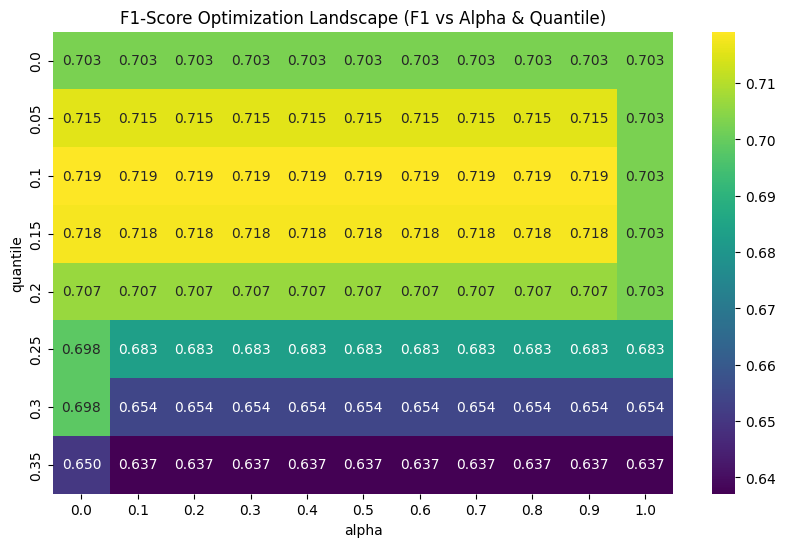

In [37]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F




print("1. Starting Grid Search to optimize Alpha and Quantile...")

# --- HYPERPARAMETER RANGE DEFINITION ---
# Alpha: Weight for Graph Centrality (0.0 = embedding similarity only; 1.0 = PageRank only)
alpha_values = np.arange(0.0, 1.1, 0.1)
# Quantile: Filtering Threshold (0.0 = no filter; 0.5 = filters the bottom 50% of scores)
quantile_values = np.arange(0.0, 0.40, 0.05)

best_f1 = -1.0
best_params = {'alpha': None, 'quantile': None}
results = []
dev_gold = [s["terms"]for s in dev_sentences]

total_iterations = len(alpha_values) * len(quantile_values)
print(f"Total combinations to test: {total_iterations}")


#Beginning of grid search
with tqdm(total=total_iterations, desc="Grid Search Progress") as pbar:
    for alpha in alpha_values:
        for q in quantile_values:

            # Apply the hybrid filter with the current parameters
            # Note: refine_predictions_with_graph_and_embeddings must be defined previously
            current_refined_preds, tau = refine_predictions_with_graph_and_embeddings(
                predictions=crf_predictions,
                centrality=centrality,
                quantile=q,
                alpha=alpha
            )

            # Evaluate the filtered output against the gold standard (dev_gold)
            # micro_f1_score returns (P, R, F, TP, FP, FN)
            P, R, F_, _, _, _ = micro_f1_score(dev_gold, current_refined_preds)

            results.append({
                'alpha': round(alpha, 2),
                'quantile': round(q, 2),
                'f1': F_,
                'precision': P,
                'recall': R
            })

            # Update the best parameters found so far
            if F_ > best_f1:
                best_f1 = F_
                best_params['alpha'] = alpha
                best_params['quantile'] = q

            pbar.update(1)


# --- FINAL REPORT ---
print("\n" + "="*60)
print("✓ OPTIMIZATION COMPLETED!")
print(f"Best F1-Score Found: {best_f1:.4f}")
print(f"Optimal Parameters: Alpha={best_params['alpha']:.1f}, Quantile={best_params['quantile']:.2f}")
print("============================================================")

# Visualization of the F1 Landscape (Heatmap)
try:
    df_results = pd.DataFrame(results)
    pivot_table = df_results.pivot(index="quantile", columns="alpha", values="f1")
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
    plt.title("F1-Score Optimization Landscape (F1 vs Alpha & Quantile)")
    plt.show()
except Exception as e:
    print("Suggestion: Install matplotlib and seaborn to visualize the heatmap.")

#Evaluation metrics after using the hybrid refinement method

In [38]:



print("Refining BERT_CRF predictions on dev set using graph + embedding similarity...")
refined_preds, tau = refine_predictions_with_graph_and_embeddings(
    crf_predictions,
    centrality,
    quantile=0.1,
    alpha=0.4 # we have seen that the value of alpha doesn't change much the results
)
print(f"Threshold tau (quantile=0.15): {tau:.6f}")

dev_gold = []

for s in dev_sentences:
  dev_gold.append(s["terms"])




# Evaluate refined predictions
ref_prec, ref_rec, ref_f1, ref_tp, ref_fp, ref_fn = micro_f1_score(dev_gold, refined_preds)
ref_type_prec, ref_type_rec, ref_type_f1 = type_f1_score(dev_gold, refined_preds)

print("\n" + "="*60)
print("GRAPH + EMBEDDING-BASED TERM REFINEMENT RESULTS (DEV)")
print("="*60)
print("\nMicro-averaged Metrics (after refinement):")
print(f"  Precision: {ref_prec:.4f}")
print(f"  Recall:    {ref_rec:.4f}")
print(f"  F1 Score:  {ref_f1:.4f}")
print(f"  TP={ref_tp}, FP={ref_fp}, FN={ref_fn}")

print("\nType-level Metrics (after refinement):")
print(f"  Type Precision: {ref_type_prec:.4f}")
print(f"  Type Recall:    {ref_type_rec:.4f}")
print(f"  Type F1 Score:  {ref_type_f1:.4f}")
print("="*60)


Refining BERT_CRF predictions on dev set using graph + embedding similarity...
Threshold tau (quantile=0.15): 0.553303

--- MICRO METRICS ---
Precision=0.7920 Type Recall=0.6585 Type F1=0.7191
Type TP=297, Type FP=78, Type FN=154

--- TYPE-LEVEL METRICS ---
Type Precision=0.7771 Type Recall=0.5620 Type F1=0.6523
Type TP=136, Type FP=39, Type FN=106

GRAPH + EMBEDDING-BASED TERM REFINEMENT RESULTS (DEV)

Micro-averaged Metrics (after refinement):
  Precision: 0.7920
  Recall:    0.6585
  F1 Score:  0.7191
  TP=297, FP=78, FN=154

Type-level Metrics (after refinement):
  Type Precision: 0.7771
  Type Recall:    0.5620
  Type F1 Score:  0.6523


#Test set predictions

In [39]:

test_raw_preds = []
model.eval()

with torch.no_grad():
    for s in test_sentences:
        # encode sentence
        ids, offsets = encode_for_inference(s["sentence_text"], tokenizer)

        # Preprocess tensors
        inp = torch.tensor([ids]).to(device)
        mask = torch.tensor([[1]*len(ids)]).to(device)

        # Predict
        pred = model(inp, mask)[0]

        # From tags back to terms
        predicted_terms = bio_to_terms(s["sentence_text"], offsets, pred)
        test_raw_preds.append(predicted_terms)

print(f"term predicted are {len(test_raw_preds)}")


term predicted are 1141


#Generate output format

In [43]:
import json
import os
import os.path
from datetime import datetime

OPTIMAL_QUANTILE = 0.15
OPTIMAL_ALPHA = 0.4
OUTPUT_DIR = "/content/test_predictions"

def format_and_save_json(predictions_list, description):

    final_output = []


    for item, pred in zip(test_data, predictions_list):
        final_output.append({
            "document_id": item.get("document_id"),
            "paragraph_id": item.get("paragraph_id"),
            "sentence_id": item.get("sentence_id"),
            "predicted_terms": pred
        })

    # Create document based on the time
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    filename = f"test_preds_{description}_{timestamp}.json"
    output_path = os.path.join(OUTPUT_DIR, filename)

    # check if the directory exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(final_output, f, ensure_ascii=False, indent=2)

    return output_path

#Output Predictions

In [45]:
print("Save prediction without refinement and with refinement separately ")



path_baseline = format_and_save_json(
    predictions_list=test_raw_preds,
    description="BASELINE"
)
print(f"baseline): {path_baseline}")


#File with the application of the filter
print("\application of optimized filter (Graph + Embeddings)...")

test_refined_preds, tau = refine_predictions_with_graph_and_embeddings(
    test_raw_preds,
    centrality,
    quantile=OPTIMAL_QUANTILE,
    alpha=OPTIMAL_ALPHA
)

# Salva l'output raffinato
path_refined = format_and_save_json(
    predictions_list=test_refined_preds,
    description="REFINED"
)
print(f"Refined implementation: {path_refined}")

Save prediction without refinement and with refinement separately 
baseline): /content/test_predictions/test_preds_BASELINE_20251129_1813.json
pplication of optimized filter (Graph + Embeddings)...
Refined implementation: /content/test_predictions/test_preds_REFINED_20251129_1813.json
